# Contents Aware Layout Generation Example.

### Model Loading

In [1]:
from src.model.minigpt4 import MiniGPT4
from src.processor.blip_processors import Blip2ImageTrainProcessor,Blip2ImageEvalProcessor,DinoImageProcessor
import torch
import json
import os
from PIL import Image
from html_to_ui import get_bbox
from generation import *
with open("log_dir/train_stage2_with_augment_dino_codellama/generated_sample/16/test_numerical.jsonl", "r") as f:
    content = [json.loads(line) for line in f]
with open("data/cgl_dataset/for_posternuwa/html_format_img_instruct_all_mask_and_all_condition/test_numerical.jsonl", "r") as f:
    sample = [json.loads(line) for line in f]
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"
vit_model_name = "dino_v2"
llama_model = "models/codeLlama-7b-hf"
base_model = "log_dir/train_stage2_with_augment_dino_codellama/checkpoints/checkpoint-16/pytorch_model.bin"
model = MiniGPT4(lora_r=64,low_resource=False,vit_model = vit_model_name,llama_model = llama_model)
model.load_state_dict(torch.load(base_model,map_location="cpu"))
model = model.to(device)
model.device = device
model.half()
model.eval()

image_processor = DinoImageProcessor()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CodeLlamaTokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/data1/poong/.conda/envs/jaepoong/lib/python3.9/site-packages/peft/utils/other.py:136: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 33,554,432 || all params: 6,772,101,120 || trainable%: 0.49548037463445316
Do not use Q-Former here.
Vit_model dino_v2
Load 1 training prompts
Prompt Example 
['[INST] <Img><ImageHere></Img> [/INST] ']


# Unconditional Layout Generation

In [2]:
img_paths = os.listdir("asset")
images = []
processed_images=[]
for path in img_paths:
    img = Image.open(os.path.join("asset",path))
    images.append(img)
    processed_images.append(image_processor(img))
processed_images = torch.stack(processed_images,dim=0)
uncond_inst = 'I want to generate layout in poster design format.plaese generate the layout html according to the image I provide (in html format):\n###bbox html: <body> <svg width="513" height="750">  </svg> </body> '
inst = [uncond_inst]*len(img_paths)

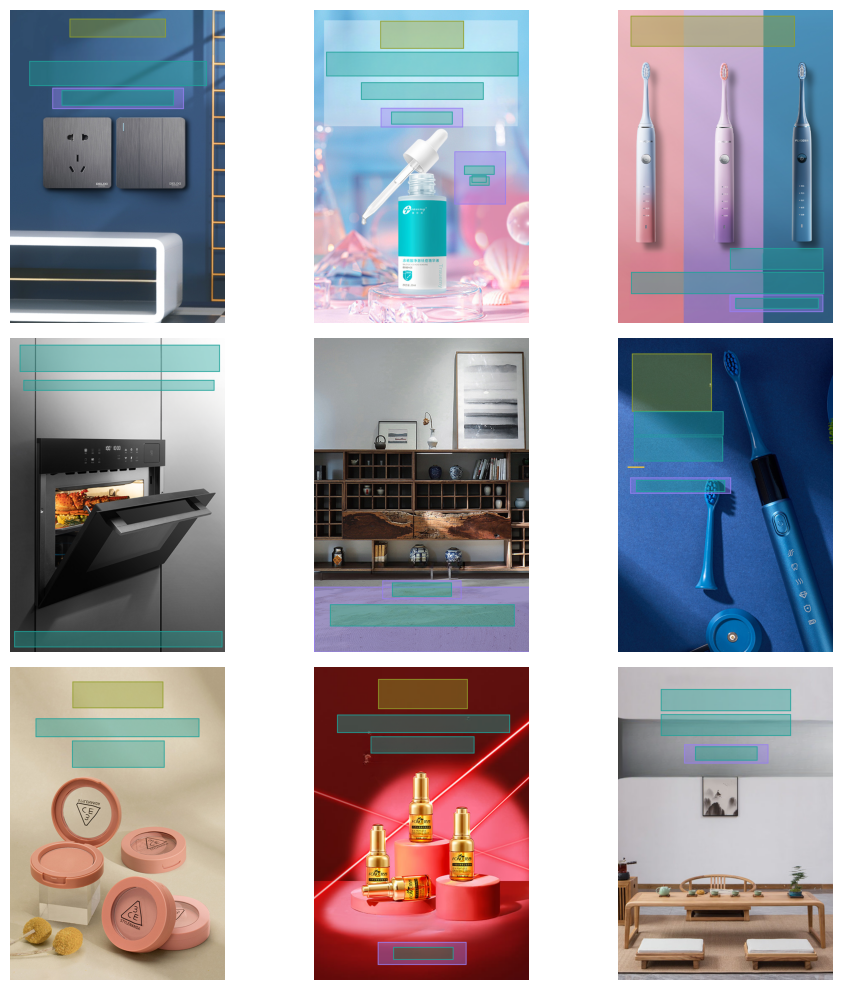

In [5]:
import matplotlib.pyplot as plt
DATASET_COLOR = {
    1: '#929F29',   
    2: '#1FA39A',  
    3: '#987FF2',      
    4: '#F56881',    
    5: "#0000FF"      
}
def sort_key(x):
    if x[0] == 3:
        return -1
    else:
        return x[0]
    
#with torch.no_grad():
#    with torch.autocast(device_type="cuda"):
#        samp = model.generate(processed_images, inst,max_new_tokens=512,do_sample=True,temperature=0.6,top_p=0.9)

layout_images = []
for i in range(len(img_paths)):
    bboxes,clses = get_bbox(samp[i])
    drawbbox = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        x2 += x1
        y2 += y1
        bbox  = [x1, y1, x2, y2]
        drawbbox.append(np.array(bbox))
    drawn_outline = images[i].copy()
    drawn_fill = images[i].copy()
    draw_ol = ImageDraw.ImageDraw(drawn_outline)
    draw_f = ImageDraw.ImageDraw(drawn_fill)


    sorted_pairs = sorted(zip(clses, drawbbox), key=sort_key)
    sorted_classes, sorted_bboxes = zip(*sorted_pairs)

    clses = list(sorted_classes)
    drawbbox = list(sorted_bboxes)

    for b,l in zip(drawbbox,clses):
        draw_ol.rectangle([b[0],b[1],b[2],b[3]], outline=DATASET_COLOR[l], width=2)
    for b,l in zip(drawbbox,clses):
        draw_f.rectangle([b[0],b[1],b[2],b[3]], fill=DATASET_COLOR[l])
    drawn_outline = drawn_outline.convert("RGBA")
    drawn_fill = drawn_fill.convert("RGBA")

    drawn_fill.putalpha(int(256 * 0.4))
    img = Image.alpha_composite(drawn_outline, drawn_fill)
    layout_images.append(img)


fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(layout_images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()